In [1]:
# импортируем все что нужно

import numpy as np
import pandas as pd
from pathlib import Path
import copy

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import shutil

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

import torch.nn.functional as F
import math

from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc

In [2]:
# пути для инпут файлов, в папке faces_aligned_pred_all лежат изображения выровненные с помощью 2_Face_alignment.ipynb
# в aligned_pred_all.csv лежат image_id и identity для этих изображений

data_path = Path("/kaggle/input/data-for-recognition/faces_aligned_pred_all")
csv_path = data_path / "aligned_pred_all.csv"

In [3]:
# проверяем сколько у нас всего выровненных изображений
file_count = len([f for f in data_path.iterdir() if f.is_file()])
file_count

25001

In [4]:
# проверяем что все выглядит ок
df = pd.read_csv(csv_path)
print(df.shape)
df.head()

(25000, 2)


,image_id,identity
0,136627.jpg,3511
1,039611.jpg,7511
2,090411.jpg,6730
3,201044.jpg,7012
4,041575.jpg,5637


Text(0.5, 1.0, 'Distribution of Images per Identity')

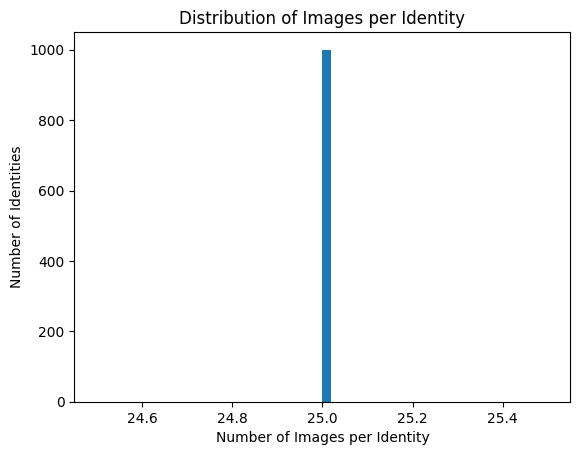

In [5]:
# проверяем что все выглядит ок
identity_counts = df['identity'].value_counts()
plt.hist(identity_counts, bins=50)
plt.xlabel("Number of Images per Identity")
plt.ylabel("Number of Identities")
plt.title("Distribution of Images per Identity")

In [6]:
output_dir_cropped = Path("/kaggle/working/faces_recognition_224")    
output_dir_cropped.mkdir(parents=True, exist_ok=True)

# так как будем использовать реснет, но дополнительно обрежем картинки до 224x224
CROP_SIZE = 224

def center_crop(img, crop_size):
    w, h = img.size
    left = (w - crop_size) // 2
    top = (h - crop_size) // 2
    return img.crop((left, top, left + crop_size, top + crop_size))

for p in tqdm(sorted(data_path.glob("*"))):

    if p.suffix.lower() == ".csv":
        continue
    
    img = Image.open(p).convert("RGB")

    crop = center_crop(img, CROP_SIZE)

    out_path = output_dir_cropped / (p.stem + ".jpg")
    crop.save(out_path, format="JPEG")

100%|██████████| 25001/25001 [02:20<00:00, 177.97it/s]


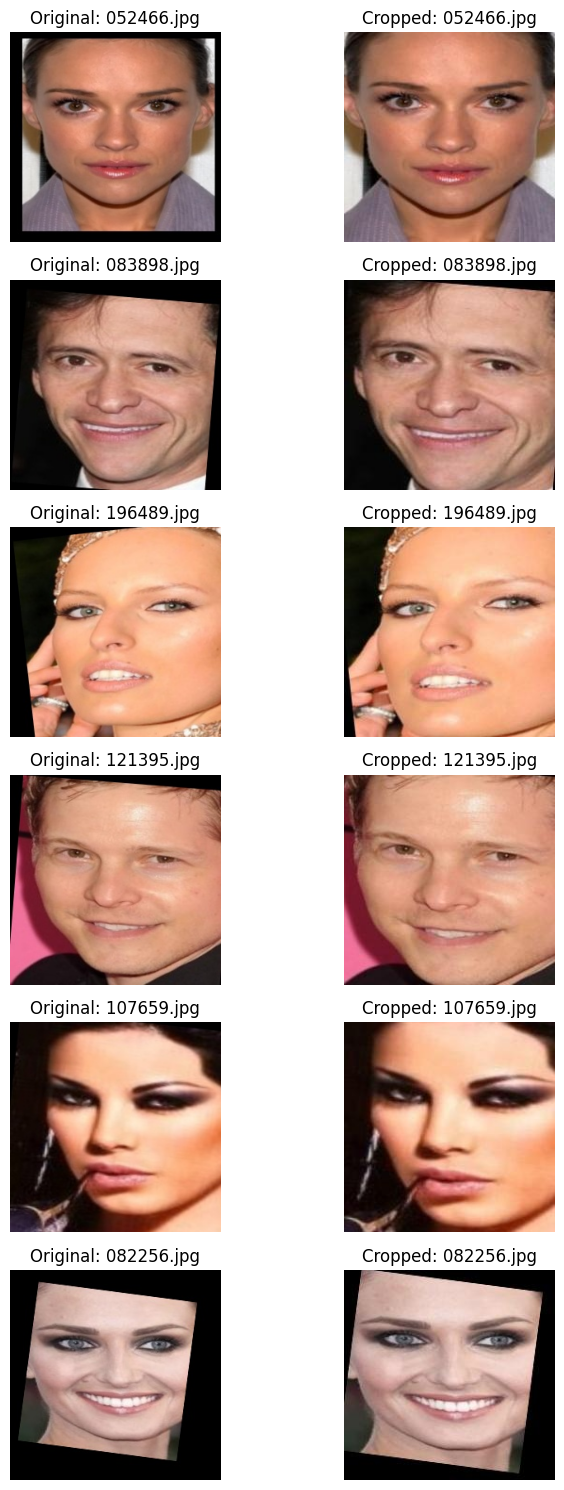

In [7]:
# отрисуем 6 рандомных картинок, чтоб проверить, что все с обрезанием все ок

sample = df.sample(6)

fig, axes = plt.subplots(6, 2, figsize=(8, 15))

for i, row in enumerate(sample.itertuples()):

    axes[i, 0].set_title(f"Original: {row.image_id}")
    img = Image.open(data_path / row.image_id)
    axes[i, 0].imshow(img)
    axes[i, 0].axis("off")

    axes[i, 1].set_title(f"Cropped: {row.image_id}")
    img_cropped = Image.open(output_dir_cropped / row.image_id)
    axes[i, 1].imshow(img_cropped)
    axes[i, 1].axis("off")

plt.tight_layout()

In [8]:
SEED = 21
rng = np.random.RandomState(SEED)

HOLDOUT_IDS = 200 # выбираем сколько идентичностей оставить для query и distractors, остальные будут для обучения и валидации 
TRAIN_PER_ID = 16 # выбираем сколько изображений на идентичность оставить для обучения, остальные будут для валидации
VAL_PER_ID = 4

In [9]:
output_dir_splits = Path("/kaggle/working/splits")
output_dir_splits.mkdir(parents=True, exist_ok=True)

for split in ["train", "val", "holdout"]:
    (output_dir_splits / split).mkdir(parents=True, exist_ok=True)

In [10]:
# берем все идентичности и перемешиваем их, чтобы случайно выбрать 200 для holdout и 800 для train/val
all_ids = sorted(df["identity"].unique().tolist())
rng.shuffle(all_ids)

holdout_ids = set(all_ids[:HOLDOUT_IDS])        
trainval_ids = set(all_ids[HOLDOUT_IDS:])       

print("holdout:", len(holdout_ids))
print("train/val:", len(trainval_ids))

holdout: 200
train/val: 800


In [11]:
# теперь для каждой идентичности копируем картинки в нужные папки

for ident, g in tqdm(df.groupby("identity"), total=df["identity"].nunique(), desc="copy splits"):
    ident = int(ident)
    ident_str = str(ident)

    g = g.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

    if ident in holdout_ids:
        split = "holdout"
        gg = g  # для holdout оставляем все 25 картинок, так как они нужны для query и distractors
        dst_dir = output_dir_splits / split / ident_str
        dst_dir.mkdir(parents=True, exist_ok=True)

        for _, r in gg.iterrows():
            src = output_dir_cropped / r["image_id"]
            dst = dst_dir / src.name
            shutil.copy2(src, dst)

        gg2 = gg.copy()
        gg2["split"] = split

    else:
        
        train_g = g.iloc[:TRAIN_PER_ID] # в train оставляем по 16 картинок для обучения, остальные 4 для валидации
        val_g   = g.iloc[TRAIN_PER_ID:TRAIN_PER_ID + VAL_PER_ID]

        for split, gg in [("train", train_g), ("val", val_g)]:
            dst_dir = output_dir_splits / split / ident_str
            dst_dir.mkdir(parents=True, exist_ok=True)

            for _, r in gg.iterrows():
                src = output_dir_cropped / r["image_id"]
                dst = dst_dir / src.name
                shutil.copy2(src, dst)

            gg2 = gg.copy()
            gg2["split"] = split

copy splits: 100%|██████████| 1000/1000 [00:06<00:00, 150.34it/s]


In [12]:
BATCH_SIZE = 128
NUM_WORKERS = 2  

# ImageNet нормализация
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

# тут я еще сверху добавил всяких преобразований, они дали норм буст в accuracy
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

eval_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

train_ds = datasets.ImageFolder(output_dir_splits / "train", transform=train_tfms)
val_ds   = datasets.ImageFolder(output_dir_splits / "val",   transform=eval_tfms)
hold_ds  = datasets.ImageFolder(output_dir_splits / "holdout", transform=eval_tfms) # на самом деле это не понадобится дальше

print("train classes:", len(train_ds.classes), "train size:", len(train_ds))
print("val classes:", len(val_ds.classes), "val size:", len(val_ds))
print("holdout classes:", len(hold_ds.classes), "holdout size:", len(hold_ds))

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

train classes: 800 train size: 12800
val classes: 800 val size: 3200
holdout classes: 200 holdout size: 5000


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_ds.classes)

In [14]:
EPOCHS = 30

In [15]:
# стандартный подсчет accuracy_top1
def accuracy_top1(logits, labels):
    correct = 0
    total = labels.size(0)

    for i in range(total):
        scores = logits[i]         
        true_label = labels[i]

        predicted_label = torch.argmax(scores)

        if predicted_label == true_label:
            correct += 1

    return correct / total

**########################**

**ниже тренируем с CE**

**########################**

In [16]:
# тут все стандартно
@torch.no_grad()
def evaluate_ce(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    n = 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_top1(logits, y) * bs
        n += bs
    return total_loss / n, total_acc / n

In [17]:
# тут все стандартно
def train_one_epoch_ce(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    n = 0
    for x, y in tqdm(loader, desc="train", leave=False):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_top1(logits, y) * bs
        n += bs
    return total_loss / n, total_acc / n

In [18]:
best_val_acc = -1.0
BEST_PATH_CE = "/kaggle/working/best_ce.pth"

In [19]:
# я попробовал пару моделей, resnet50 показала лучшие результаты
model_ce = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
model_ce.fc = nn.Linear(model_ce.fc.in_features, num_classes)
model_ce = model_ce.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s]


In [20]:
# тут все стандартно
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model_ce.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [21]:
# тренируем с CE

history_ce = []

history_ce = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
}

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch_ce(model_ce, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate_ce(model_ce, val_loader, criterion, device)
    scheduler.step()

    history_ce["train_loss"].append(train_loss)
    history_ce["val_loss"].append(val_loss)
    history_ce["train_acc"].append(train_acc)
    history_ce["val_acc"].append(val_acc)
    
    print(f"Epoch {epoch:02d} train_loss={train_loss:.4f} train_acc = {train_acc:.4f} val_loss={val_loss:.4f} val_acc = {val_acc:.4f} ")

    # сохраняем веса лучшей модели
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "epoch": epoch,
            "model_state_dict": model_ce.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_val_acc": best_val_acc,
            "classes": train_ds.classes,
            "meta": {
                "arch": "CE",
                "backbone": "resnet50",
                "input_size": 224,
            },
        }, BEST_PATH_CE)
        print(f"!!! Saved best checkpoint, val_acc={best_val_acc:.4f})")

Epoch 01 train_loss=6.4130 train_acc = 0.0087 val_loss=5.7370 val_acc = 0.0391 
!!! Saved best checkpoint, val_acc=0.0391)


Epoch 02 train_loss=4.8719 train_acc = 0.1441 val_loss=4.4802 val_acc = 0.2037 
!!! Saved best checkpoint, val_acc=0.2037)


Epoch 03 train_loss=3.4578 train_acc = 0.4263 val_loss=3.5775 val_acc = 0.4041 
!!! Saved best checkpoint, val_acc=0.4041)


Epoch 04 train_loss=2.5819 train_acc = 0.6623 val_loss=3.1043 val_acc = 0.5219 
!!! Saved best checkpoint, val_acc=0.5219)


Epoch 05 train_loss=2.0333 train_acc = 0.8161 val_loss=2.7638 val_acc = 0.6162 
!!! Saved best checkpoint, val_acc=0.6162)


Epoch 06 train_loss=1.6710 train_acc = 0.9203 val_loss=2.5107 val_acc = 0.6744 
!!! Saved best checkpoint, val_acc=0.6744)


Epoch 07 train_loss=1.4421 train_acc = 0.9714 val_loss=2.3557 val_acc = 0.7147 
!!! Saved best checkpoint, val_acc=0.7147)


Epoch 08 train_loss=1.3151 train_acc = 0.9913 val_loss=2.2096 val_acc = 0.7659 
!!! Saved best checkpoint, val_acc=0.7659)


Epoch 09 train_loss=1.2347 train_acc = 0.9985 val_loss=2.1063 val_acc = 0.7872 
!!! Saved best checkpoint, val_acc=0.7872)


Epoch 10 train_loss=1.1884 train_acc = 0.9997 val_loss=2.0948 val_acc = 0.7963 
!!! Saved best checkpoint, val_acc=0.7963)


Epoch 11 train_loss=1.1607 train_acc = 0.9998 val_loss=2.0603 val_acc = 0.8109 
!!! Saved best checkpoint, val_acc=0.8109)


Epoch 12 train_loss=1.1403 train_acc = 0.9998 val_loss=2.0560 val_acc = 0.8306 
!!! Saved best checkpoint, val_acc=0.8306)


Epoch 13 train_loss=1.1230 train_acc = 0.9998 val_loss=2.0239 val_acc = 0.8366 
!!! Saved best checkpoint, val_acc=0.8366)


Epoch 14 train_loss=1.1099 train_acc = 0.9998 val_loss=2.0185 val_acc = 0.8431 
!!! Saved best checkpoint, val_acc=0.8431)


Epoch 15 train_loss=1.0989 train_acc = 0.9998 val_loss=2.0206 val_acc = 0.8481 
!!! Saved best checkpoint, val_acc=0.8481)


Epoch 16 train_loss=1.0922 train_acc = 0.9998 val_loss=2.0142 val_acc = 0.8522 
!!! Saved best checkpoint, val_acc=0.8522)


Epoch 17 train_loss=1.0838 train_acc = 0.9998 val_loss=1.9934 val_acc = 0.8550 
!!! Saved best checkpoint, val_acc=0.8550)


Epoch 18 train_loss=1.0749 train_acc = 0.9999 val_loss=2.0240 val_acc = 0.8541 


Epoch 19 train_loss=1.0696 train_acc = 0.9999 val_loss=2.0261 val_acc = 0.8678 
!!! Saved best checkpoint, val_acc=0.8678)


Epoch 20 train_loss=1.0645 train_acc = 0.9999 val_loss=2.0158 val_acc = 0.8722 
!!! Saved best checkpoint, val_acc=0.8722)


Epoch 21 train_loss=1.0598 train_acc = 0.9998 val_loss=2.0224 val_acc = 0.8703 


Epoch 22 train_loss=1.0564 train_acc = 0.9999 val_loss=2.0109 val_acc = 0.8691 


Epoch 23 train_loss=1.0526 train_acc = 0.9998 val_loss=2.0300 val_acc = 0.8728 
!!! Saved best checkpoint, val_acc=0.8728)


Epoch 24 train_loss=1.0503 train_acc = 0.9998 val_loss=2.0205 val_acc = 0.8734 
!!! Saved best checkpoint, val_acc=0.8734)


Epoch 25 train_loss=1.0480 train_acc = 0.9998 val_loss=2.0259 val_acc = 0.8741 
!!! Saved best checkpoint, val_acc=0.8741)


Epoch 26 train_loss=1.0461 train_acc = 0.9999 val_loss=2.0334 val_acc = 0.8734 


Epoch 27 train_loss=1.0450 train_acc = 0.9999 val_loss=2.0333 val_acc = 0.8762 
!!! Saved best checkpoint, val_acc=0.8762)


Epoch 28 train_loss=1.0442 train_acc = 0.9998 val_loss=2.0387 val_acc = 0.8753 


Epoch 29 train_loss=1.0433 train_acc = 1.0000 val_loss=2.0404 val_acc = 0.8750 


Epoch 30 train_loss=1.0433 train_acc = 0.9999 val_loss=2.0370 val_acc = 0.8750 


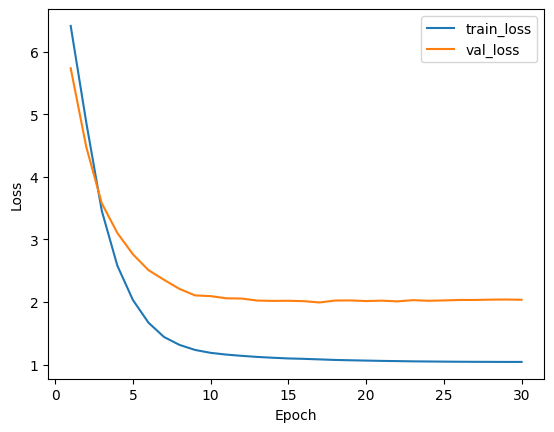

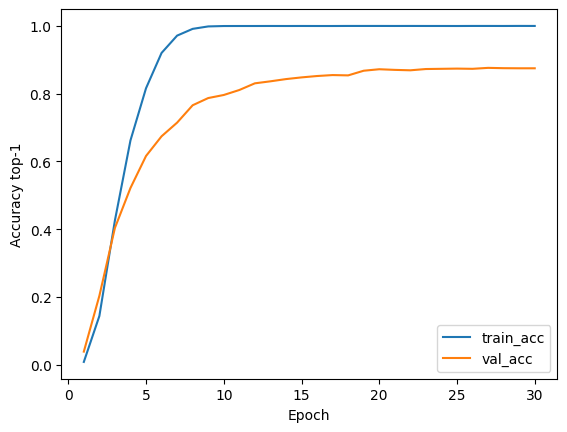

In [22]:
# отрисуем лоссы и accuracy как функции количества эпо   

epochs = range(1, len(history_ce["train_loss"]) + 1)

plt.figure()
plt.plot(list(epochs), history_ce["train_loss"])
plt.plot(list(epochs), history_ce["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train_loss", "val_loss"])
plt.show()

plt.figure()
plt.plot(list(epochs), history_ce["train_acc"])
plt.plot(list(epochs), history_ce["val_acc"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy top-1")
plt.legend(["train_acc", "val_acc"])
plt.show()

In [23]:
# загрузим лучшую модель

ckpt = torch.load(BEST_PATH_CE, map_location=device)
best_model_ce = copy.deepcopy(model_ce)
best_model_ce.load_state_dict(ckpt["model_state_dict"])
best_model_ce.to(device).eval()
print("Best epoch:", ckpt.get("epoch"), "best_val_acc:", ckpt.get("best_val_acc"))

Best epoch: 27 best_val_acc: 0.87625


**########################**

**ниже тренируем с ArcFace**

**########################**

In [24]:
# все стандартно

@torch.no_grad()
def evaluate_af(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    n = 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

        logits, emb = model(x, labels=None) # тут маржин не нужен!
        loss = criterion(logits, y)
        
        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_top1(logits, y) * bs
        n += bs
    return total_loss / n, total_acc / n

In [25]:
# все стандартно

def train_one_epoch_af(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    n = 0
    for x, y in tqdm(loader, desc="train", leave=False):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        logits, emb = model(x, labels=y) # применяем маржин!      
        loss = criterion(logits, y)
        
        loss.backward()
        optimizer.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_top1(logits, y) * bs
        n += bs
    return total_loss / n, total_acc / n

In [26]:
best_val_acc = -1.0
BEST_PATH_AF = "/kaggle/working/best_af.pth"

In [27]:
# ArcFace голова
class ArcMarginProduct(nn.Module):
 
    def __init__(self, in_features, out_features, s, m):
        super().__init__()

        self.in_features = in_features # размерность эмбеддинга
        self.out_features = out_features # число identites

        self.s = float(s) # масштаб логитов 
        self.m = float(m) # угловой маржин

        self.weight = nn.Parameter(torch.empty(out_features, in_features)) # матрица весов классов, каждая строка это "центр" класса в пространстве эмбеддингов
        nn.init.xavier_uniform_(self.weight) 

        # Предварительно считаем cos(m), sin(m) для формулы:
        # cos(theta + m) = cos(theta)*cos(m) - sin(theta)*sin(m)
        self.cos_m = math.cos(self.m) 
        self.sin_m = math.sin(self.m)

        # порог и поправка для численной стабильности 
        self.th = math.cos(math.pi - self.m)
        self.mm = math.sin(math.pi - self.m) * self.m

    def forward(self, embeddings, labels=None):

        # L2-нормализация эмбеддингов и весов:
        embeddings = F.normalize(embeddings, p=2, dim=1)      
        weight = F.normalize(self.weight, p=2, dim=1)        

        # перемножаем их
        cosine = F.linear(embeddings, weight)              

        # Если labels нет, то возвращаем чистые cosine * s
        # маржин нужен только при обучении чтобы формировать пространство эмбеддингов
        if labels is None:
            return cosine * self.s

        # считаем sin(theta) = sqrt(1 - cos^2(theta))
        # clamp нужен, чтобы не получить отрицательное из-за численных ошибок
        sine = torch.sqrt(torch.clamp(1.0 - cosine**2, min=0.0))

        # читаем phi = cos(theta + m) по формуле, вот и пригодилась тригонометрия!
        phi = cosine * self.cos_m - sine * self.sin_m        

        # если cosine слишком маленький (угол тета слишком большой), то вместе phi = cos(theta + m) используем phi = cosine - mm
        # это делается для численной стабильности, потому что если teta + m окажется больше pi, то cos перестанет быть монотонной функцией угла и у нас будут проблемы с обучением
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        # оne-hot для выбора ground-truth в каждом примере
        one_hot = torch.zeros_like(cosine)                    
        one_hot.scatter_(1, labels.view(-1, 1), 1.0)

        # для правильного класса phi = cos(theta + m)
        # для остальных классов cosine = cos(theta)
        logits = one_hot * phi + (1.0 - one_hot) * cosine

        # масштабируем логиты
        logits = logits * self.s
        return logits


In [28]:
# сама ArcFace модель

class ArcFaceModel(nn.Module):
    def __init__(self, backbone, embedder, head):
        super().__init__()
        self.backbone = backbone
        self.embedder = embedder
        self.head = head

    def forward(self, x, labels=None):
        # backbone извлекает признаки
        features = self.backbone(x)

        # embedder переводит признаки в пространстве эмбеддингов
        emb = self.embedder(features)

        # ArcFace голова считает логиты
        logits = self.head(emb, labels)

        return logits, emb

In [29]:
# берем опять resnet50 в качестве backbone

backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
in_features = backbone.fc.in_features
backbone.fc = nn.Identity()  # выкидываем классификатор

EMB_DIM = 512 # размерность эмбеддинга, как в оригинальной статье ArcFace

# строим embedder
embedder = nn.Sequential(
    nn.Linear(in_features, EMB_DIM, bias=False),
    nn.BatchNorm1d(EMB_DIM),
)

# дефотльные гиперпараметры для ArcFace
S = 30.0
M = 0.50
head = ArcMarginProduct(EMB_DIM, num_classes, s=S, m=M)

model_af = ArcFaceModel(backbone, embedder, head).to(device)

In [30]:
# все как и для CE
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model_af.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [31]:
# тоже все как для CE

history_af = []

history_af = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
}

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch_af(model_af, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate_af(model_af, val_loader, criterion, device)
    scheduler.step()

    history_af["train_loss"].append(train_loss)
    history_af["val_loss"].append(val_loss)
    history_af["train_acc"].append(train_acc)
    history_af["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d} train_loss={train_loss:.4f} train_acc = {train_acc:.4f} val_loss={val_loss:.4f} val_acc = {val_acc:.4f} ")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "epoch": epoch,
            "best_val_acc": best_val_acc,
            "model_state_dict": model_af.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "classes": train_ds.classes,
            "arcface_s": S,
            "arcface_m": M,
            "emb_dim": EMB_DIM,
            "meta": {
                "arch": "ArcFace",
                "backbone": "resnet50",
                "input_size": 224,
            },
        }, BEST_PATH_AF)
        print(f"!!! Saved best checkpoint, val_acc={best_val_acc:.4f}")

Epoch 01 train_loss=19.1531 train_acc = 0.0000 val_loss=4.8888 val_acc = 0.1503 
!!! Saved best checkpoint, val_acc=0.1503


Epoch 02 train_loss=16.4052 train_acc = 0.0001 val_loss=3.3558 val_acc = 0.4669 
!!! Saved best checkpoint, val_acc=0.4669


Epoch 03 train_loss=13.2110 train_acc = 0.0092 val_loss=2.6468 val_acc = 0.6619 
!!! Saved best checkpoint, val_acc=0.6619


Epoch 04 train_loss=9.9949 train_acc = 0.0614 val_loss=2.4437 val_acc = 0.7544 
!!! Saved best checkpoint, val_acc=0.7544


Epoch 05 train_loss=7.4395 train_acc = 0.1709 val_loss=2.2710 val_acc = 0.8488 
!!! Saved best checkpoint, val_acc=0.8488


Epoch 06 train_loss=5.5797 train_acc = 0.3113 val_loss=2.2632 val_acc = 0.8747 
!!! Saved best checkpoint, val_acc=0.8747


Epoch 07 train_loss=4.2810 train_acc = 0.4462 val_loss=2.2838 val_acc = 0.8847 
!!! Saved best checkpoint, val_acc=0.8847


Epoch 08 train_loss=3.2380 train_acc = 0.5934 val_loss=2.3028 val_acc = 0.9044 
!!! Saved best checkpoint, val_acc=0.9044


Epoch 09 train_loss=2.5496 train_acc = 0.7198 val_loss=2.3169 val_acc = 0.9087 
!!! Saved best checkpoint, val_acc=0.9087


Epoch 10 train_loss=2.0629 train_acc = 0.8149 val_loss=2.3198 val_acc = 0.9153 
!!! Saved best checkpoint, val_acc=0.9153


Epoch 11 train_loss=1.7733 train_acc = 0.8867 val_loss=2.3294 val_acc = 0.9072 


Epoch 12 train_loss=1.5937 train_acc = 0.9318 val_loss=2.3256 val_acc = 0.9131 


Epoch 13 train_loss=1.5043 train_acc = 0.9542 val_loss=2.3034 val_acc = 0.9172 
!!! Saved best checkpoint, val_acc=0.9172


Epoch 14 train_loss=1.4311 train_acc = 0.9712 val_loss=2.3003 val_acc = 0.9156 


Epoch 15 train_loss=1.3921 train_acc = 0.9805 val_loss=2.2746 val_acc = 0.9209 
!!! Saved best checkpoint, val_acc=0.9209


Epoch 16 train_loss=1.3642 train_acc = 0.9820 val_loss=2.2764 val_acc = 0.9231 
!!! Saved best checkpoint, val_acc=0.9231


Epoch 17 train_loss=1.3304 train_acc = 0.9906 val_loss=2.2570 val_acc = 0.9231 


Epoch 18 train_loss=1.3099 train_acc = 0.9908 val_loss=2.2561 val_acc = 0.9206 


Epoch 19 train_loss=1.2857 train_acc = 0.9947 val_loss=2.2419 val_acc = 0.9244 
!!! Saved best checkpoint, val_acc=0.9244


Epoch 20 train_loss=1.2689 train_acc = 0.9961 val_loss=2.2393 val_acc = 0.9216 


Epoch 21 train_loss=1.2565 train_acc = 0.9964 val_loss=2.2358 val_acc = 0.9225 


Epoch 22 train_loss=1.2408 train_acc = 0.9975 val_loss=2.2293 val_acc = 0.9206 


Epoch 23 train_loss=1.2285 train_acc = 0.9984 val_loss=2.2269 val_acc = 0.9209 


Epoch 24 train_loss=1.2203 train_acc = 0.9984 val_loss=2.2269 val_acc = 0.9228 


Epoch 25 train_loss=1.2136 train_acc = 0.9987 val_loss=2.2226 val_acc = 0.9225 


Epoch 26 train_loss=1.2099 train_acc = 0.9984 val_loss=2.2181 val_acc = 0.9213 


Epoch 27 train_loss=1.2054 train_acc = 0.9987 val_loss=2.2177 val_acc = 0.9234 


Epoch 28 train_loss=1.2033 train_acc = 0.9993 val_loss=2.2168 val_acc = 0.9216 


Epoch 29 train_loss=1.2014 train_acc = 0.9991 val_loss=2.2164 val_acc = 0.9234 


Epoch 30 train_loss=1.2005 train_acc = 0.9991 val_loss=2.2170 val_acc = 0.9228 


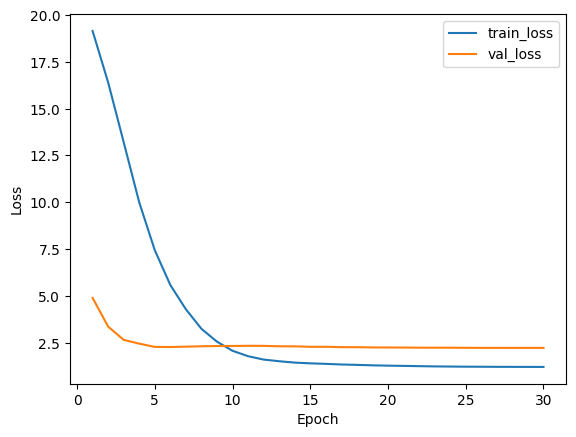

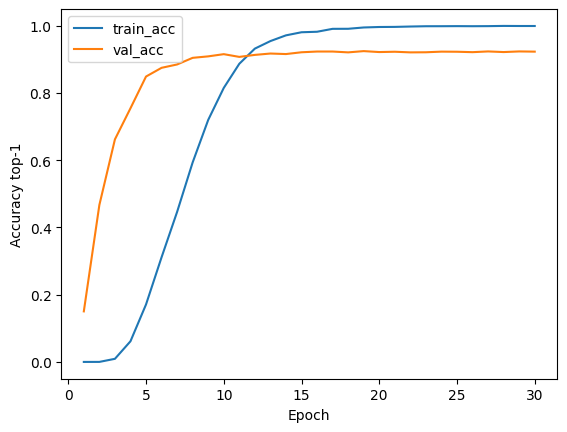

In [32]:
# отрисуем лоссы и accuracy как функции количества эпоx  

epochs = range(1, len(history_af["train_loss"]) + 1)

plt.figure()
plt.plot(list(epochs), history_af["train_loss"])
plt.plot(list(epochs), history_af["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train_loss", "val_loss"])
plt.show()

plt.figure()
plt.plot(list(epochs), history_af["train_acc"])
plt.plot(list(epochs), history_af["val_acc"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy top-1")
plt.legend(["train_acc", "val_acc"])
plt.show()

In [33]:
# загрузим лучшую модель
ckpt = torch.load(BEST_PATH_AF, map_location=device)
best_model_af = copy.deepcopy(model_af)
best_model_af.load_state_dict(ckpt["model_state_dict"])
best_model_af.to(device).eval()
print("Best epoch:", ckpt.get("epoch"), "best_val_acc:", ckpt.get("best_val_acc"))

Best epoch: 19 best_val_acc: 0.924375


########################

тут начинаем считать IRM

########################

In [34]:
# вытаскиваем эмбеддер из CE модели (то есть выкидываем последний линейный слой)
ce_emb_model = copy.deepcopy(best_model_ce)
ce_emb_model.fc = torch.nn.Identity()
ce_emb_model = ce_emb_model.to(device).eval()

# Arcface модель уже содержит эмбеддер
arc_model = best_model_af.to(device).eval()

In [35]:
# считаем эмбеддинги для батча картинок x

@torch.no_grad()
def ce_forward_embeddings(model, x):
    z = model(x)  
    z = z.float()
    z = F.normalize(z, p=2, dim=1) # не забываем нормализовать
    return z

@torch.no_grad()
def arcface_forward_embeddings(model, x):
    feat = model.backbone(x)
    z = model.embedder(feat)
    z = z.float()
    z = F.normalize(z, p=2, dim=1)
    return z

In [36]:
# создаем словарь, где ключ это идентичность (класс), а значение это список путей к картинкам этой идентичности в holdout датасете
by_class = {}

for img_path, class_idx in hold_ds.samples:
    by_class.setdefault(class_idx, []).append(img_path)

# список всех идентичностей в holdout
all_hold_classes = sorted(by_class.keys())

# перемешиваем их, чтобы случайно выбрать 100 для query и 100 для distractors
rng.shuffle(all_hold_classes)

In [37]:
N_QUERY_IDS = 100  # ограничиваем число идентичностей в query, чтобы IR computation оставался быстрым
Q_PER_ID = 2   # сколько картинок на идентичность оставить в query
D_PER_ID = 5   # сколько картинок на идентичность оставить в distractors

# разделяем идентичности
query_classes = all_hold_classes[:N_QUERY_IDS]
distractor_classes = all_hold_classes[N_QUERY_IDS:]


In [38]:
query_dict = {}
query_img_names = []

for cid in query_classes:
    imgs = by_class[cid].copy()
    rng.shuffle(imgs)

    # для каждой идентичности в query случайно выбираем Q_PER_ID картинок
    imgs = imgs[:Q_PER_ID]

    query_dict[cid] = imgs
    query_img_names.extend(imgs)

distractors_img_names = []

for cid in distractor_classes:
    imgs = by_class[cid].copy()
    rng.shuffle(imgs)

    # для каждой идентичности в distractors случайно выбираем D_PER_ID картинок
    imgs = imgs[:D_PER_ID]

    distractors_img_names.extend(imgs)

In [39]:
# функция для подсчета эмбеддингов из списка путей к картинкам

@torch.no_grad()
def compute_embeddings_from_paths(paths, model, forward_fn, batch_size):


    all_emb = []

    # пробегаемся по батчам
    for i in range(0, len(paths), batch_size):

        batch_paths = paths[i:i+batch_size]

        imgs = []

        # загружаем и преобразуем картинки
        for p in batch_paths:
            img = Image.open(p).convert("RGB")
            imgs.append(eval_tfms(img))

        x = torch.stack(imgs).to(device, non_blocking=True)

        # считаем эмбеддинги
        z = forward_fn(model, x)  
        all_emb.append(z.cpu().numpy())

    return np.concatenate(all_emb, axis=0)

In [40]:
# считаем эмбеддинги для query и distractors для CE

query_emb_ce = compute_embeddings_from_paths(query_img_names, ce_emb_model, ce_forward_embeddings, batch_size=256)
distr_emb_ce = compute_embeddings_from_paths(distractors_img_names, ce_emb_model, ce_forward_embeddings, batch_size=256)

In [41]:
# считаем эмбеддинги для query и distractors для AF

query_emb_af = compute_embeddings_from_paths(query_img_names, arc_model, arcface_forward_embeddings, batch_size=256)
distr_emb_af = compute_embeddings_from_paths(distractors_img_names, arc_model, arcface_forward_embeddings, batch_size=256)

In [42]:
# косинусная похожесть
def cos_sim(a, b):
    return float(np.dot(a, b))

# считаем косинусные похожести для одинаковых идентичностей (положительные пары)
def cosine_query_pos(query_dict, query_paths, query_emb):

    name2idx = {p: i for i, p in enumerate(query_paths)}
    sims = []

    for cid, imgs in query_dict.items():

        idxs = [name2idx[p] for p in imgs]

        # all pairs inside same identity
        for i in range(len(idxs)):
            for j in range(i + 1, len(idxs)):
                sims.append(cos_sim(query_emb[idxs[i]],
                                    query_emb[idxs[j]]))

    return sims

# считаем косинусные похожести для разных идентичностей (отрицательные пары)
def cosine_query_neg(query_dict, query_paths, query_emb):

    name2idx = {p: i for i, p in enumerate(query_paths)}
    classes = list(query_dict.keys())
    sims = []

    for i in range(len(classes)):
        for j in range(i + 1, len(classes)):

            imgs_i = query_dict[classes[i]]
            imgs_j = query_dict[classes[j]]

            for pi in imgs_i:
                for pj in imgs_j:
                    sims.append(cos_sim(query_emb[name2idx[pi]],
                                        query_emb[name2idx[pj]]))

    return sims


# считаем косинусные похожести между query и distractors
def cosine_query_distr(query_emb, distr_emb):

    sims = []

    for a in query_emb:
        for b in distr_emb:
            sims.append(cos_sim(a, b))

    return sims


# считаем IR (threshold и TPR) при заданном FPR
def compute_ir(pos, neg_q, neg_d, fpr):

    negatives = np.array(list(neg_q) + list(neg_d))
    positives = np.array(pos)

    # определяем порог по отрицательным примерам при заданном FPR
    threshold = np.quantile(negatives, 1.0 - fpr)

    # определяем TPR по положительным примерам при этом пороге
    tpr = np.mean(positives >= threshold)

    return threshold, tpr

In [43]:
# считаем косинусные похожести для CE модели
pos_ce  = cosine_query_pos(query_dict, query_img_names, query_emb_ce)
negq_ce = cosine_query_neg(query_dict, query_img_names, query_emb_ce)
negd_ce = cosine_query_distr(query_emb_ce, distr_emb_ce)

In [44]:
# считаем косинусные похожести для AF модели
pos_af  = cosine_query_pos(query_dict, query_img_names, query_emb_af)
negq_af = cosine_query_neg(query_dict, query_img_names, query_emb_af)
negd_af = cosine_query_distr(query_emb_af, distr_emb_af)

In [45]:
# определяем FPRs для которых будем считать IR
FPRS = [0.5, 0.2, 0.1, 0.05]

# считаем и выводим IR для CE и AF моделей
for fpr in FPRS:
    thr_ce, tpr_ce = compute_ir(pos_ce, negq_ce, negd_ce, fpr)
    thr_af, tpr_af = compute_ir(pos_af, negq_af, negd_af, fpr)
    print(f"FPR={fpr:.2f}  CE threshold={thr_ce:.4f} CE TPR={tpr_ce:.4f} Arcface threshold={thr_af:.4f} Arcface TPR={tpr_af:.4f}")

FPR=0.50  CE threshold=0.3130 CE TPR=0.9800 Arcface threshold=0.0025 Arcface TPR=0.9700
FPR=0.20  CE threshold=0.4134 CE TPR=0.9500 Arcface threshold=0.0679 Arcface TPR=0.9200
FPR=0.10  CE threshold=0.4706 CE TPR=0.8700 Arcface threshold=0.1047 Arcface TPR=0.8600
FPR=0.05  CE threshold=0.5173 CE TPR=0.7800 Arcface threshold=0.1386 Arcface TPR=0.8100
